In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
import time
import os
from dotenv import load_dotenv
os.environ["USE_PYGEOS"] = "0"
import napari_sparrow as nas
from spatialdata import read_zarr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
%run own_and_modified_functions.ipynb
warnings.simplefilter(action='ignore')

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


In [2]:
OUTPUT_DIR = '/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data'
sdata = read_zarr( os.path.join(  OUTPUT_DIR, 'sdata.zarr'  ) )
anndata = sc.read('/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/anndataNucA11') # reset original anndata
# delete anndata
del sdata.table
# create anndata
sdata.table = anndata
sdata

SpatialData object with:
├── Images
│     ├── 'clahe': SpatialImage[cyx] (1, 12864, 10720)
│     ├── 'raw_image': SpatialImage[cyx] (1, 12864, 10720)
│     ├── 'tiling_correction': SpatialImage[cyx] (1, 12864, 10720)
│     ├── 'tophat_filtered': SpatialImage[cyx] (1, 12864, 10720)
│     └── 'transcript_density': SpatialImage[cyx] (1, 12864, 10720)
├── Labels
│     └── 'segmentation_mask': SpatialImage[yx] (12864, 10720)
├── Points
│     └── 'transcripts': DataFrame with shape: (4754932, 3) (2D points)
├── Shapes
│     ├── 'expanded_cells20': GeoDataFrame shape: (11228, 1) (2D shapes)
│     ├── 'filtered_expanded_cells20_low_counts': GeoDataFrame shape: (367, 1) (2D shapes)
│     ├── 'filtered_expanded_cells20_segmentation': GeoDataFrame shape: (50, 1) (2D shapes)
│     ├── 'filtered_expanded_cells20_size': GeoDataFrame shape: (280, 1) (2D shapes)
│     ├── 'filtered_segmentation_mask_boundaries_low_counts': GeoDataFrame shape: (367, 1) (2D shapes)
│     ├── 'filtered_segmentation_mask_

In [3]:
# count the number of principal components that explain at least 1% of the variance
n_pca = np.count_nonzero(sdata.table.uns['pca']['variance_ratio'] > 0.01)
n_pca
# play with the number of neighbors 
# Larger values result in more global views of the manifold, while smaller values result in more local data being preserved. 
# In general values should be in the range 2 to 100, default = 15
n_neighb = 15
# play with the cluster resolution
# A parameter value controlling the coarseness of the clustering. Higher values lead to more clusters. default = 1 
n_clust_res = 1

In [4]:
make_umap_and_perform_leiden_annotation(sdata,n_PCAs=n_pca,n_neighbors=n_neighb,cluster_resolution=n_clust_res)

In [5]:
suffix = '_' + str(n_pca) + '_' + str(n_neighb) + '_' + str(n_clust_res) 
suffix_short = '_' + str(n_pca) + '_' + str(n_neighb) 

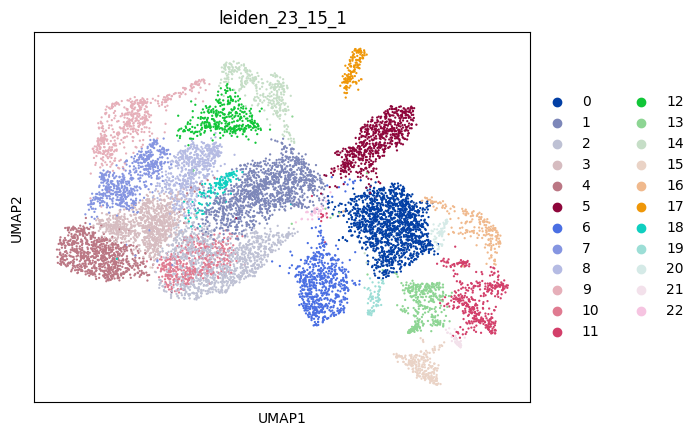

0     0.126024
1     0.107143
2     0.097257
3     0.081315
4     0.073566
5     0.059227
6     0.056733
7     0.052547
8     0.051300
9     0.044888
10    0.037496
11    0.036961
12    0.032419
13    0.031439
14    0.028678
15    0.021642
16    0.018080
17    0.013270
18    0.011845
19    0.005967
20    0.005166
21    0.003741
22    0.003295
Name: leiden_23_15_1, dtype: float64


In [6]:
path_mg = "/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/markerGeneListBasic.csv"
visualize_classification(sdata,'leiden'+suffix,'umap'+suffix_short,path_mg,plot_dot_plot=False,plot_rank_genes_groups=False,plot_image=False)

In [7]:
sdata.table.uns['mapping_cell_type_leiden'+suffix]

{'B cell': ['1', '17', '22'],
 'Chol': ['15'],
 'Endo': ['16', '19'],
 'Fibr': ['11'],
 'Hepa': ['2', '3', '4', '7', '8', '9', '10', '12', '14', '18'],
 'Kupf': ['5'],
 'LSEC': ['0', '20'],
 'Oth': ['13', '21'],
 'Stel': ['6']}

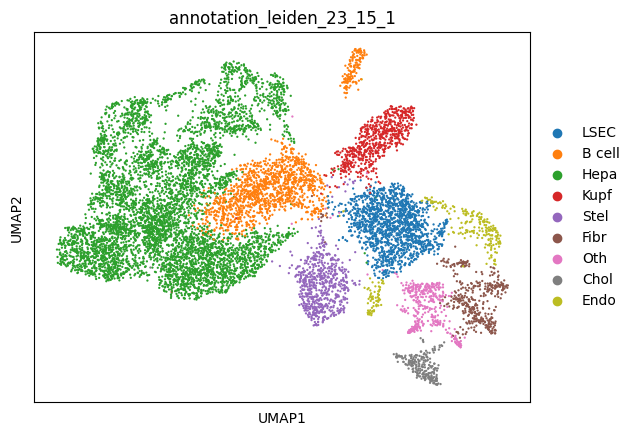

Hepa      0.511311
LSEC      0.131190
B cell    0.123709
Kupf      0.059227
Stel      0.056733
Fibr      0.036961
Oth       0.035180
Endo      0.024047
Chol      0.021642
Name: annotation_leiden_23_15_1, dtype: float64


In [8]:
visualize_classification(sdata,'annotation_leiden'+suffix,'umap'+suffix_short,path_mg,plot_dot_plot=False,plot_rank_genes_groups=False,plot_image=False)

In [9]:
sdata

SpatialData object with:
├── Images
│     ├── 'clahe': SpatialImage[cyx] (1, 12864, 10720)
│     ├── 'raw_image': SpatialImage[cyx] (1, 12864, 10720)
│     ├── 'tiling_correction': SpatialImage[cyx] (1, 12864, 10720)
│     ├── 'tophat_filtered': SpatialImage[cyx] (1, 12864, 10720)
│     └── 'transcript_density': SpatialImage[cyx] (1, 12864, 10720)
├── Labels
│     └── 'segmentation_mask': SpatialImage[yx] (12864, 10720)
├── Points
│     └── 'transcripts': DataFrame with shape: (4754932, 3) (2D points)
├── Shapes
│     ├── 'expanded_cells20': GeoDataFrame shape: (11228, 1) (2D shapes)
│     ├── 'filtered_expanded_cells20_low_counts': GeoDataFrame shape: (367, 1) (2D shapes)
│     ├── 'filtered_expanded_cells20_segmentation': GeoDataFrame shape: (50, 1) (2D shapes)
│     ├── 'filtered_expanded_cells20_size': GeoDataFrame shape: (280, 1) (2D shapes)
│     ├── 'filtered_segmentation_mask_boundaries_low_counts': GeoDataFrame shape: (367, 1) (2D shapes)
│     ├── 'filtered_segmentation_mask_